## Creating a Model for Kaggle Titanic Competition

### Importing Packages and loading dataset

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error
import torch
from torch import tensor
import torch.nn.functional as F

In [3]:
train_data = pd.read_csv("train.csv")
test_data = pd.read_csv("test.csv")
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

train_model will be where we put the variables for the model to use

In [5]:
train_model = pd.DataFrame()
train_model["Survived"] = train_data["Survived"]

### Looking at the different Variables

#### Looking at Sex variable

We can see from the graph below that females are more likely to survive than males.

<Axes: >

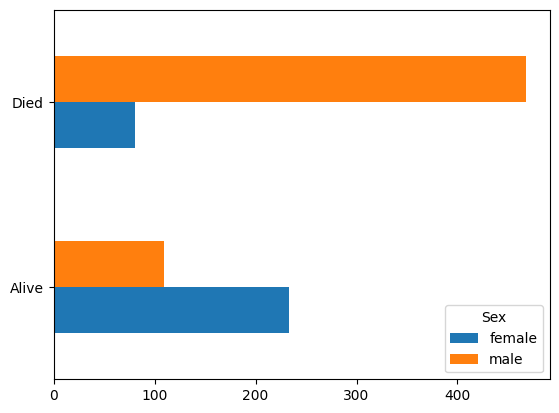

In [6]:
alive = train_data[train_data["Survived"] == 1]["Sex"].value_counts()
dead = train_data[train_data["Survived"] == 0]["Sex"].value_counts()
df = pd.DataFrame([alive, dead])
df.index = ["Alive", "Died"]
df.plot(kind = 'barh')

Need to change it from int64 to binary so that it can be used by the models

In [7]:
train_model["Sex"] = train_data["Sex"] == "male"
train_model.head()

,Survived,Sex
0,0,True
1,1,False
2,1,False
3,1,False
4,0,True


#### Looking at pclass

People who had a 3rd class ticket seem to be alot more likely to die than the people with 2nd and 1rst class tickets. People with 1rst class tickets even had a higher than 50% chance to survive. 

<Axes: >

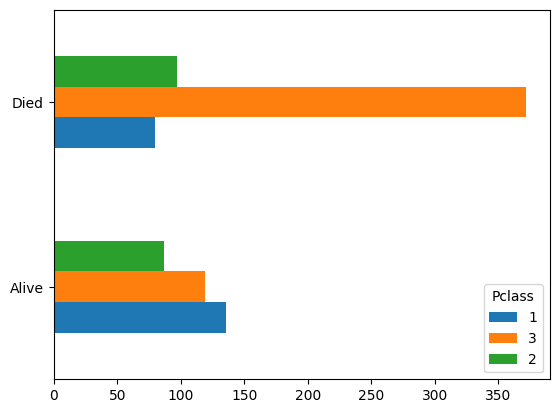

In [8]:
alive = train_data[train_data["Survived"] == 1]["Pclass"].value_counts()
dead = train_data[train_data["Survived"] == 0]["Pclass"].value_counts()
df = pd.DataFrame([alive, dead])
df.index = ["Alive", "Died"]
df.plot(kind = 'barh')

Need to one-hot encode Pclass

In [9]:
train_model["Pclass1"] = train_data["Pclass"] == 1
train_model["Pclass2"] = train_data["Pclass"] == 2
train_model["Pclass3"] = train_data["Pclass"] == 3
train_model.head()

,Survived,Sex,Pclass1,Pclass2,Pclass3
0,0,True,False,False,True
1,1,False,True,False,False
2,1,False,False,False,True
3,1,False,True,False,False
4,0,True,False,False,True


#### Looking at Name variable

Seems to be alot of different and unique names. Very hard to get data from this. We will instead draw marital and social status from their title. Ex: Mr., Mrs., Miss., etc.

In [10]:
train_data["Name"].value_counts()

Name
Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: count, Length: 891, dtype: int64

In [11]:
i = 0
while (i< len(train_data["Name"])):
    train_model.loc[i, "Name_Mr"] = ("Mr." in train_data.loc[i, "Name"])
    i += 1
    
i = 0
while (i< len(train_data["Name"])):
    train_model.loc[i, "Name_Mrs"] = ("Mrs." in train_data.loc[i, "Name"])
    i += 1
    
i = 0
while (i< len(train_data["Name"])):
    train_model.loc[i, "Name_Miss"] = ("Miss." in train_data.loc[i, "Name"])
    i += 1

Looking at the graph below. People with the title Mr were very likely to not survive. Meanwhile, Married women (Mrs) had the highest rate of survival. 

<Axes: xlabel='Survived'>

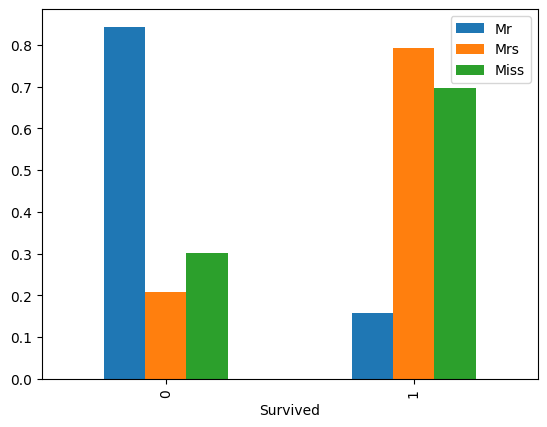

In [12]:
Mr = train_model[train_model["Name_Mr"] == True]["Survived"].value_counts()
Mrs = train_model[train_model["Name_Mrs"] == True]["Survived"].value_counts()
Miss = train_model[train_model["Name_Miss"] == True]["Survived"].value_counts()


Mr = Mr/sum(Mr)
Mrs = Mrs/sum(Mrs)
Miss = Miss/sum(Miss)

d = {"Mr": Mr, "Mrs": Mrs, "Miss": Miss}
df = pd.DataFrame(d)
df.plot(kind = 'bar')

In [13]:
train_model.head()

,Survived,Sex,Pclass1,Pclass2,Pclass3,Name_Mr,Name_Mrs,Name_Miss
0,0,True,False,False,True,True,False,False
1,1,False,True,False,False,False,True,False
2,1,False,False,False,True,False,False,True
3,1,False,True,False,False,False,True,False
4,0,True,False,False,True,True,False,False


#### Looking at Age

Age also has some NA values. We can replace it by the mean of the group since the values seem to be around a 30. Could also replace it with the mean of subgroups to get more accuracy.

<Axes: ylabel='Density'>

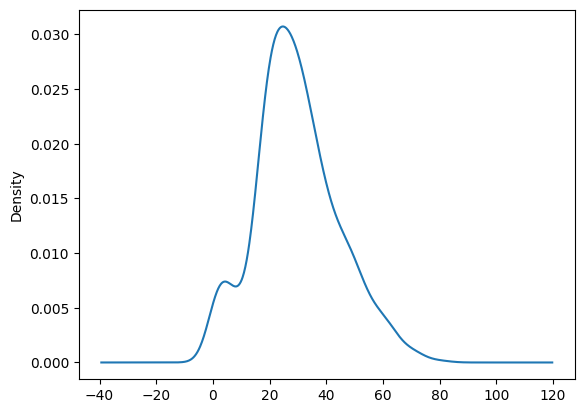

In [14]:
ages = train_data["Age"]
ages.plot(kind = "density")

In [15]:
train_model["Age"] = train_data["Age"]

i = 0
mean = train_model["Age"].mean(skipna = True)
while (i < len(train_model["Age"])):
    if (math.isnan(train_model.loc[i, "Age"])):
        train_model.loc[i, "Age"] = mean
    i += 1


In [16]:
print(train_model["Age"].isna().sum())
train_data["Age"].value_counts()

0


Age
24.00    30
22.00    27
18.00    26
19.00    25
28.00    25
         ..
36.50     1
55.50     1
0.92      1
23.50     1
74.00     1
Name: count, Length: 88, dtype: int64

#### Looking at Embarked

We can again one hot encode this variable while also removing the na values

In [17]:
train_data["Embarked"].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

The graph shows that people embarked from C had a higher than 50% chance of surviving while the other groups had drastically lower chances.

<Axes: >

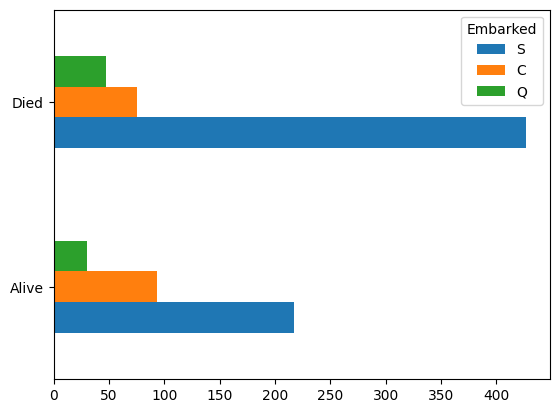

In [18]:
alive = train_data[train_data["Survived"] == 1]["Embarked"].value_counts()
dead = train_data[train_data["Survived"] == 0]["Embarked"].value_counts()
df = pd.DataFrame([alive, dead])
df.index = ["Alive", "Died"]
df.plot(kind = 'barh')

In [19]:
train_model["S_embarked"] = train_data["Embarked"] == "S"
train_model["C_embarked"] = train_data["Embarked"] == "C"
train_model["Q_embarked"] = train_data["Embarked"] == "Q"

In [20]:
train_model.head()

,Survived,Sex,Pclass1,Pclass2,Pclass3,Name_Mr,Name_Mrs,Name_Miss,Age,S_embarked,C_embarked,Q_embarked
0,0,True,False,False,True,True,False,False,22.0,True,False,False
1,1,False,True,False,False,False,True,False,38.0,False,True,False
2,1,False,False,False,True,False,False,True,26.0,True,False,False
3,1,False,True,False,False,False,True,False,35.0,True,False,False
4,0,True,False,False,True,True,False,False,35.0,True,False,False


#### Looking at Cabin

Its hard to draw information from Cabin number so we will take the floor letter from them. 
Has alot of missing values. Its hard to do anything with these so we will just designate the missing ones as missing.

In [21]:
train_data["Cabin"].value_counts()

Cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: count, Length: 147, dtype: int64

In [22]:
i = 0
while (i< len(train_data["Cabin"])):
    if (pd.isna(train_data.loc[i, "Cabin"])):
        train_data.loc[i, "Cabin"] = 'Missing'
    i += 1
    
train_data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         2
dtype: int64

In [23]:
train_data["Cabin Letter"] = train_data["Cabin"]
i = 0
while (i< len(train_data["Cabin"])):
    train_data.loc[i, "Cabin Letter"] = train_data.loc[i, "Cabin"][0]
    i += 1

In [24]:
train_data["Cabin Letter"].value_counts()

Cabin Letter
M    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64

In [25]:
train_model["Cabin_A"] = train_data["Cabin Letter"] == "A"
train_model["Cabin_B"] = train_data["Cabin Letter"] == "B"
train_model["Cabin_C"] = train_data["Cabin Letter"] == "C"
train_model["Cabin_D"] = train_data["Cabin Letter"] == "D"
train_model["Cabin_E"] = train_data["Cabin Letter"] == "E"
train_model["Cabin_F"] = train_data["Cabin Letter"] == "F"
train_model["Cabin_G"] = train_data["Cabin Letter"] == "G"
train_model["Cabin_T"] = train_data["Cabin Letter"] == "T"
train_model["Cabin_M"] = train_data["Cabin Letter"] == "M"

<Axes: xlabel='Survived'>

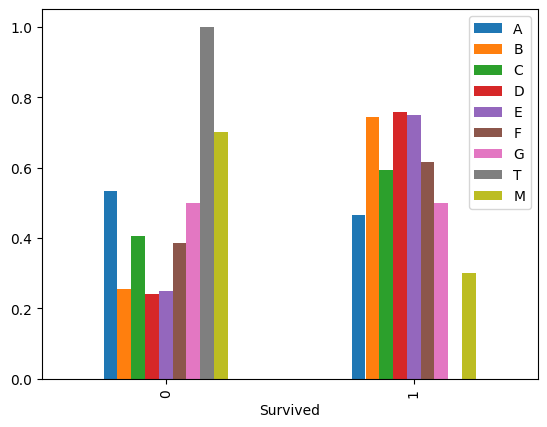

In [26]:
A = train_model[train_model["Cabin_A"] == True]["Survived"].value_counts()
B = train_model[train_model["Cabin_B"] == True]["Survived"].value_counts()
C = train_model[train_model["Cabin_C"] == True]["Survived"].value_counts()
D = train_model[train_model["Cabin_D"] == True]["Survived"].value_counts()
E = train_model[train_model["Cabin_E"] == True]["Survived"].value_counts()
F = train_model[train_model["Cabin_F"] == True]["Survived"].value_counts()
G = train_model[train_model["Cabin_G"] == True]["Survived"].value_counts()
T = train_model[train_model["Cabin_T"] == True]["Survived"].value_counts()
M = train_model[train_model["Cabin_M"] == True]["Survived"].value_counts()

A = A/sum(A)
B = B/sum(B)
C = C/sum(C)
D = D/sum(D)
E = E/sum(E)
F = F/sum(F)
G = G/sum(G)
T = T/sum(T)
M = M/sum(M)

d = {"A": A, "B": B, "C": C, "D": D, "E": E, "F": F, "G": G, "T": T, "M": M}
df = pd.DataFrame(d)
df.plot(kind = 'bar')

It seems from the graph that Cabin floor does have an effect on survival odds. We could add on to this by grouping the floors to get better categorical predictors.

In [27]:
train_model.head()

,Survived,Sex,Pclass1,Pclass2,Pclass3,Name_Mr,Name_Mrs,Name_Miss,Age,S_embarked,...,Q_embarked,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_M
0,0,True,False,False,True,True,False,False,22.0,True,...,False,False,False,False,False,False,False,False,False,True
1,1,False,True,False,False,False,True,False,38.0,False,...,False,False,False,True,False,False,False,False,False,False
2,1,False,False,False,True,False,False,True,26.0,True,...,False,False,False,False,False,False,False,False,False,True
3,1,False,True,False,False,False,True,False,35.0,True,...,False,False,False,True,False,False,False,False,False,False
4,0,True,False,False,True,True,False,False,35.0,True,...,False,False,False,False,False,False,False,False,False,True


#### Looking at SibSp

<Axes: >

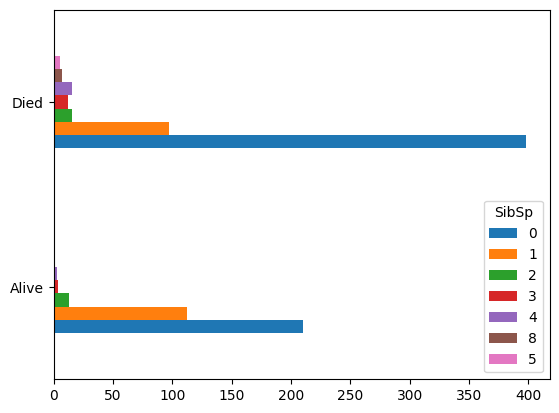

In [28]:
alive = train_data[train_data["Survived"] == 1]["SibSp"].value_counts()
dead = train_data[train_data["Survived"] == 0]["SibSp"].value_counts()
df = pd.DataFrame([alive, dead])
df.index = ["Alive", "Died"]
df.plot(kind = 'barh')

It seems that a lower SibSp could mean a lower odd for survival. We might want to create categorical variables based on this.

In [29]:
train_model["SibSp"] = train_data["SibSp"]

#### Looking at Parch

<Axes: >

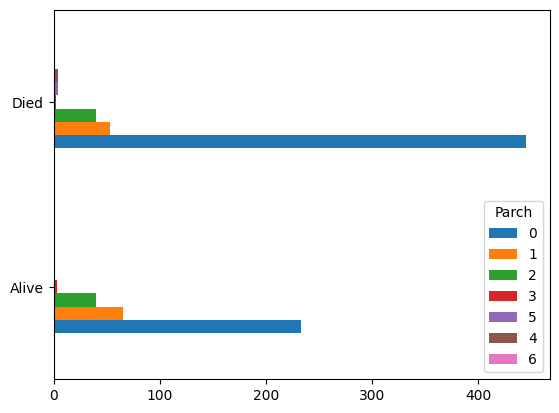

In [30]:
alive = train_data[train_data["Survived"] == 1]["Parch"].value_counts()
dead = train_data[train_data["Survived"] == 0]["Parch"].value_counts()
df = pd.DataFrame([alive, dead])
df.index = ["Alive", "Died"]
df.plot(kind = 'barh')

It seems that a higher Parch might increase the odds of survival. We may want to group these variables to create a family size categorical variable.

In [31]:
train_model["Parch"] = train_data["Parch"]

#### Looking at Fare

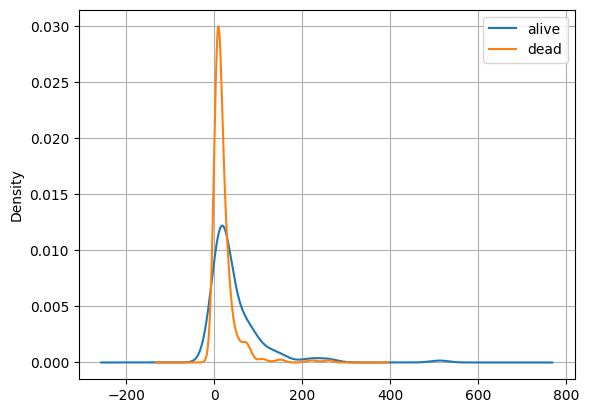

In [32]:
alive = train_data[train_data["Survived"]==1]["Fare"]
dead = train_data[train_data["Survived"]==0]["Fare"]
alive.plot(kind = "kde", label = "alive")
dead.plot(kind = "kde", label = "dead")
plt.legend()
plt.grid()
plt.show()

This graph shows that more people that spent more on the fare survived compared to people who spent less. The peak of the alive curve is also slightly farther to the right showing this. 

In [33]:
train_model["Fare"] = train_data["Fare"]

### Creating the model

#### Creating the training and validation data sets

In [34]:
train_model.head()

,Survived,Sex,Pclass1,Pclass2,Pclass3,Name_Mr,Name_Mrs,Name_Miss,Age,S_embarked,...,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_M,SibSp,Parch,Fare
0,0,True,False,False,True,True,False,False,22.0,True,...,False,False,False,False,False,False,True,1,0,7.2500
1,1,False,True,False,False,False,True,False,38.0,False,...,True,False,False,False,False,False,False,1,0,71.2833
2,1,False,False,False,True,False,False,True,26.0,True,...,False,False,False,False,False,False,True,0,0,7.9250
3,1,False,True,False,False,False,True,False,35.0,True,...,True,False,False,False,False,False,False,1,0,53.1000
4,0,True,False,False,True,True,False,False,35.0,True,...,False,False,False,False,False,False,True,0,0,8.0500


In [35]:
X = train_model[["Pclass1", "Pclass2", "Pclass3", "Sex", "Age", "SibSp", "Parch", "Fare", "S_embarked", "C_embarked", "Q_embarked", "Name_Mr", "Name_Mrs", "Name_Miss", "Cabin_M", "Cabin_C", "Cabin_B", "Cabin_D", "Cabin_E", "Cabin_A", "Cabin_F", "Cabin_G", "Cabin_T"]]
y = train_model["Survived"]
#Splits the data so we can validate the model
train_X, val_X, train_y, val_y = train_test_split(X,y, random_state = 5, test_size = 0.25)

#### Support Vector Machine Model

In [36]:
SVM_Model = SVC()
SVM_Model.fit(train_X, train_y)

SVC()

In [37]:
mean_absolute_error(SVM_Model.predict(val_X), val_y)

0.28699551569506726

#### Random Forest Classifier Model

In [38]:
RFC_Model = RandomForestClassifier()
RFC_Model.fit(X, y)

RandomForestClassifier()

In [39]:
mean_absolute_error(RFC_Model.predict(val_X), val_y)

0.013452914798206279

#### Decision Tree Classifier Model

In [40]:
DTC_Model = DecisionTreeClassifier(random_state = 1)
DTC_Model.fit(train_X, train_y)

DecisionTreeClassifier(random_state=1)

In [41]:
mean_absolute_error(DTC_Model.predict(val_X), val_y)

0.21076233183856502

#### Neural Network


In [42]:
train_X.head()

,Pclass1,Pclass2,Pclass3,Sex,Age,SibSp,Parch,Fare,S_embarked,C_embarked,...,Name_Miss,Cabin_M,Cabin_C,Cabin_B,Cabin_D,Cabin_E,Cabin_A,Cabin_F,Cabin_G,Cabin_T
97,True,False,False,True,23.000000,0,1,63.3583,False,True,...,False,False,False,False,True,False,False,False,False,False
742,True,False,False,False,21.000000,2,2,262.3750,False,True,...,True,False,False,True,False,False,False,False,False,False
754,False,True,False,False,48.000000,1,2,65.0000,True,False,...,False,True,False,False,False,False,False,False,False,False
839,True,False,False,True,29.699118,0,0,29.7000,False,True,...,False,False,True,False,False,False,False,False,False,False
184,False,False,True,False,4.000000,0,2,22.0250,True,False,...,True,True,False,False,False,False,False,False,False,False


In [43]:
indep_cols = ['Pclass1', 'Pclass2', 'Pclass3', 'Sex', 'Age', 'SibSp', 'Parch', 'LogFare', 'S_embarked',
       'C_embarked', 'Q_embarked', 'Name_Mr', 'Name_Mrs', 'Name_Miss',
       'Cabin_M', 'Cabin_C', 'Cabin_B', 'Cabin_D', 'Cabin_E', 'Cabin_A',
       'Cabin_F', 'Cabin_G']
train_X['LogFare'] = np.log(train_X['Fare']+1)
val_X['LogFare'] = np.log(val_X['Fare']+1)

t_train_X = tensor(train_X[indep_cols].astype(int).values, dtype=torch.float)
t_train_y = tensor(train_y.values, dtype=torch.float)
t_val_X = tensor(val_X[indep_cols].astype(int).values, dtype=torch.float)
t_val_y = tensor(val_y.values, dtype=torch.float)

vals_X,indices_X = t_train_X.max(dim=0)
vals_y,indices_y = t_train_y.max(dim=0)
t_train_X = t_train_X / vals_X
t_train_y = t_train_y /vals_y
t_train_y = t_train_y[:,None]
t_val_y = t_val_y[:,None]

In [44]:
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()
    
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, t_train_X, t_train_y)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")
    
def init_coeffs():
    n_coeff = t_train_X.shape[1]
    hiddens = [10, 10] 
    sizes = [n_coeff] + hiddens + [1]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

def train_model(epochs=30, lr=0.01):
    torch.manual_seed(123)
    coeffs = init_coeffs()
    for i in range(epochs): one_epoch(coeffs, lr=lr)
    return coeffs

def calc_preds(coeffs, indeps):
    layers,consts = coeffs
    n = len(layers)
    res = indeps
    for i,l in enumerate(layers):
        res = res@l + consts[i]
        if i!=n-1: res = F.relu(res)
    return torch.sigmoid(res)

def update_coeffs(coeffs, lr):
    layers,consts = coeffs
    for layer in layers+consts:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()
        
def calc_loss(coeffs, indeps, deps): 
    return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

def acc(coeffs): 
    return (t_train_y.bool()==(calc_preds(coeffs, t_train_X)>0.5)).float().mean()

play around with epochs and learning rate to find a good fit.

In [45]:
coeffs = train_model(epochs=600, lr=0.1)

AttributeError: 'Series' object has no attribute 'relu'

In [ ]:
acc(coeffs)

tensor(0.8084)

#### Ensemble

In [ ]:
prediction_RFC = RFC_Model.predict(train_X)
prediction_SVM = SVM_Model.predict(train_X)
prediction_DTC = DTC_Model.predict(train_X)

NameError: name 'RFC_Model' is not defined

In [ ]:
predictions_mean = (prediction_RFC + prediction_SVM + prediction_DTC)/3
predictions_mean = predictions_mean > 0.5
prediction = predictions_mean.astype(int)